# Processing natural language with Neural Networks

In [0]:
%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


In [0]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

## Data downloads

Sentiment Analysis

http://ai.stanford.edu/~amaas/data/sentiment/

### Embeddings

Download embeddings data (**not necessary for all the exercises**).

Several research groups and companies share embeddings for natural languages, that have been obtained by different methods over large corpuses of text. Here we will use one of these datasets of embeddings for the English language, and will evaluate if these embeddings improve our model.

https://nlp.stanford.edu/projects/glove/

In [0]:
%%bash
if [ ! -d data/aclImdb/ ]; then
  curl http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz > aclImdb_v1.tar.gz
fi

# Only for some exercises
#if [ ! -f data/glove/glove.6B.100d.txt ]; then
#   curl https://nlp.stanford.edu/data/glove.6B.zip > glove.6B.zip 
#fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  29.1M      0  0:00:02  0:00:02 --:--:-- 29.1M


In [0]:
# Check that the downloads look ok
!ls -hl

total 81M
-rw-r--r-- 1 root root  81M Jan 11 18:38 aclImdb_v1.tar.gz
drwxr-xr-x 1 root root 4.0K Jan  8 17:15 sample_data


### Data uncompress

In [0]:
%%bash
if [ ! -d data/aclImdb/ ]; then
  mkdir -p data
  mv aclImdb_v1.tar.gz data/
  cd data && tar zxf aclImdb_v1.tar.gz && rm aclImdb_v1.tar.gz
else
  echo "Skipping. IMDB data already uncompressed."
 fi

In [0]:
!ls data/aclImdb/

In [0]:
!cat data/aclImdb/train/pos/0_9.txt | head

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!

# Data preparation for the Neural Network

In [0]:
import os

In [0]:
d = {}
datasets = ['test', 'train']
labels = ['pos', 'neg']

base_path = 'data/aclImdb/'

for dataset in datasets:
  d[dataset] = {'text': [], 'y':[]}
  for label in labels:
    y = 1 if label == 'pos' else 0
    txt_dir = os.path.join(base_path, dataset, label)
    fns = os.listdir(txt_dir)
    for fn in fns:
      # Leemos el fichero
      with open(os.path.join(txt_dir, fn), 'r') as f:
        txt = ' '.join(f.readlines())
        # add el texto a la lista del dict
        d[dataset]['text'].append(txt)
        d[dataset]['y'].append(y)
      

In [0]:
d['test']['text'][1]

'"A Fare to Remember" is a totally derivative, almost ridiculous movie, but has a warmth about it that makes it a very effective and upbeat holiday movie. It stars a pretty newcomer, Challen Kates, as a high-powered ad executive who, right before her wedding, has to rush from L.A. to Seattle to keep a client who has rejected every other presentation. She has transportation difficulties from the beginning and seemingly no money. This is the first dumb thing - were there no ATMs anywhere? She must make a fortune. At any rate, she meets a cab driver (Warner) who looks like a homeless man, and he drives her to her presentation and when she emerges with a huge box of beef jerky (the client\'s product), he\'s there to take her to the airport. All flights are canceled, so in order to get to L.A. for her wedding, she hires him to take her there.<br /><br />Along the way, they bond and learn from each other. It\'s a very sweet movie though there is absolutely nothing new in it - it combines "Si

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [0]:
VOCABULARY_SIZE = 1000

In [0]:
tokenizer = Tokenizer(VOCABULARY_SIZE)

In [0]:
tokenizer.fit_on_texts(d['train']['text'])

In [0]:
x_train = tokenizer.texts_to_matrix(d['train']['text'])

In [0]:
x_test = tokenizer.texts_to_matrix(d['test']['text'])

In [0]:
y_train = np.array(d['train']['y'])

In [0]:
y_test = np.array(d['test']['y'])

In [0]:
x_train_seq = tokenizer.texts_to_sequences(d['train']['text'])

# Model architecture

In [0]:
import tensorflow as tf

In [0]:
def keras2tpu(m):
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    m,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))

  return tpu_model

In [0]:
from tensorflow.keras import models, layers, losses, optimizers, metrics

In [0]:
def build_model():
  m = models.Sequential()
  m.add(layers.Dense(512, activation='relu', input_shape = (VOCABULARY_SIZE,)))
  m.add(layers.Dense(256, activation='relu'))
  m.add(layers.Dense(128, activation='relu'))
  m.add(layers.Dense(64, activation='relu'))
  m.add(layers.Dense(32, activation='relu'))
  m.add(layers.Dense(1, activation='sigmoid'))
  
  return keras2tpu(m)

In [0]:
m_1h = build_model()

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.0.58.26:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 738758414794881908)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16066802142350613686)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 13901980663580253083)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12587913212030599559)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4157646713347753573)
INFO:tensorflow:*** Available Device: _DeviceAt

In [0]:
m_1h.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total para

In [0]:
m_1h.compile(loss=losses.binary_crossentropy, optimizer=optimizers.RMSprop(), metric=[metrics.binary_accuracy])

INFO:tensorflow:Cloning RMSprop {'lr': 0.0010000000474974513, 'rho': 0.8999999761581421, 'decay': 0.0, 'epsilon': 1e-07}


In [0]:
h = m_1h.fit(x_train, y_train, epochs=40, batch_size=2048, validation_data=[x_test, y_test])

Train on 25000 samples, validate on 25000 samples
Epoch 1/40
25000/25000 [==============================] - 2s 70us/step - loss: 1.2861e-07 - val_loss: 1.5622
Epoch 2/40
25000/25000 [==============================] - 2s 66us/step - loss: 1.2243e-07 - val_loss: 1.5723
Epoch 3/40
25000/25000 [==============================] - 2s 65us/step - loss: 1.1847e-07 - val_loss: 1.5830
Epoch 4/40
25000/25000 [==============================] - 2s 71us/step - loss: 1.1606e-07 - val_loss: 1.5898
Epoch 5/40
25000/25000 [==============================] - 2s 65us/step - loss: 1.1452e-07 - val_loss: 1.5993
Epoch 6/40
25000/25000 [==============================] - 2s 65us/step - loss: 1.1349e-07 - val_loss: 1.6056
Epoch 7/40
25000/25000 [==============================] - 2s 65us/step - loss: 1.1247e-07 - val_loss: 1.6134
Epoch 8/40
25000/25000 [==============================] - 2s 64us/step - loss: 1.1219e-07 - val_loss: 1.6204
Epoch 9/40
25000/25000 [==============================] - 2s 66us/step - loss:

# Training

# Quick evaluation of performance

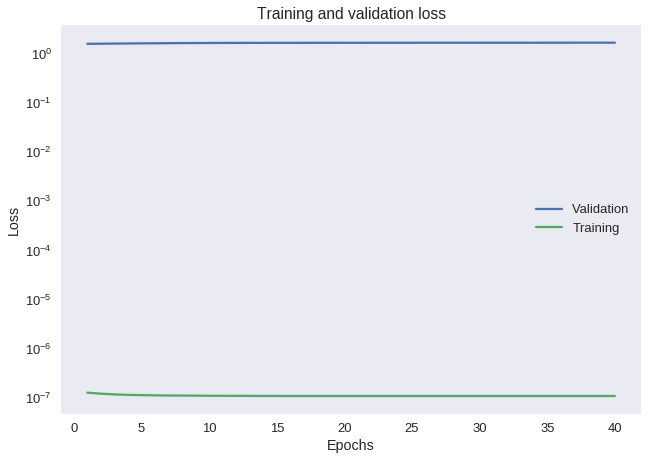

In [0]:
plot_metric(h, 'loss')

# Detailed evaluation of text classifier